##Magnetic Force Simulator

This is a software suite designed to simulate the distribution and forces between fictious "point magnetic charges" as they appear on magnetized surfaces. Limited functionality right now in terms of availible geometries and charge distributions, but can be expanded. There are some improper implementations of inheritance issues which have yet to be fixed.

Plotting of charge distributions and corresponding forces as a function of gaps is made availible via matplotlib. 

Designed by Primus Lam in 2015 for Surgitronic Inc. 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%run source/magnet_define.py
%run source/magnet_shapes.py

<b>Magnet object definitions</b>
<br>
These methods define the point charges and collections of point charges for magnets. The essential method here is field_at, which computes the superimposed field at points at specific coordinates.

In [13]:
'''
A single point magnetic charge is defined by a coordinate and a magnitude. 
It induces field according to the inverse square law on distance from it.
'''
class magnetic_charge:
    mu_naught = 4*math.pi*10**-7
    multiplier = 1/(4*math.pi*mu_naught)
    def __init__(self, coordinate, magnitude):
        self.c = coordinate
        self.m = magnitude
    
    # returns a vector corresponding to the magnetic field at x, y
    def field_at(self, coordinate):
        # print("The charge is ", self, ", the target location is", "({}, {})".format(x, y))
        dc = coordinate - self.c
        r = np.linalg.norm(dc)
        return dc*self.m*self.multiplier/r**3
        
    def __str__(self):
        return "{} at {}".format(self.m, self.c)
    def __repr__(self):
        return "magnetic_charge({}, {})".format(self.c, self.m)
    
'''        
A distribution of magnetic charges which are fixed in relative position is referred to as a magnet.
Ideally, the net magnitude of positive and negative charges within a magnet is zero, as there are no
magnetic monopoles. 
'''
class magnet:
    def __init__(self, charges, color = 'b'):
        self.charges = np.array([])
        self.color = color
        for charge in charges:
            self.charges = np.append(self.charges, charge)
            
    # returns a vector corresponding to the superimposed magnetic field at x, y
    def field_at(self, coordinate):
        output = np.array([0, 0, 0])
        for charge in self.charges:
            output = output + charge.field_at(coordinate)
        return output
        
    # returns a vector corresponding to the sum of the vector forces on another magnet 
    # by summing the forces on each of its charges
    def force_on(self, other):
        output = np.array([0, 0, 0])
        for charge in other.charges:
            output = output + charge.m*self.field_at(charge.c)
        return output
        
    def __add__(self, other):
        return magnet(np.append(self.charges, other.charges))
    def __str__(self):
        return str(self.charges)
    
      
def plot_magnet(magnets, max_range = .03):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    n = 100
    for magnet in magnets:
        c, m = (magnet.color, 'o')
        xs = np.array([])
        ys = np.array([])
        zs = np.array([])
        for charge in magnet.charges:
            xs = np.append(xs, charge.c[0])
            ys = np.append(ys, charge.c[1])
            zs = np.append(zs, charge.c[2])
        ax.scatter(xs, ys, zs, c=c, marker=m)

    ax.set_xlim(0 - max_range, 0 + max_range)
    ax.set_ylim(0 - max_range, 0 + max_range)
    ax.set_zlim(0 - max_range, 0 + max_range)
        
    ax.set_xlabel('X (meters)')
    ax.set_ylabel('Y (meters)')
    ax.set_zlabel('Z (meters)')

    plt.show()

<b>Predefined magnet shapes</b>
<br>
These are some predefined magnet shapes for convenience in simulation.
Each of them take certain geometric parameters, but the essential magnetic strength computation comes from the argument b, which represents the magnitude of $\overrightarrow{B}$, the  B-field through the surface of the magnet.

In [3]:
'''
Some constants to be changed for the tradeoff between runtme and accuracy
'''
DENSITY = 4
SLICES = 5

In [4]:
class ring_magnet(magnet):
    def __init__(self, center, r1, r2, m, b, color = 'b'):
        self.charges = np.array([])
        self.color = color
        theta = 2*math.pi/m
        area = math.pi*(r1**2 - r2**2)/m
        magnitude = b*area
        r_prime = 0.5*(r1+r2)
        for i in range(m):
            coordinate = center + np.array([r_prime*math.cos(i*theta), r_prime*math.sin(i*theta), 0])
            self.charges = np.append(self.charges, magnetic_charge(coordinate, magnitude))

class disk_magnet(magnet):
    def __init__(self, center, r1, r2, n, b, color = 'b'):
        self.color = color
        self.charges = np.array([])
        thickness = (r2-r1)/n
        for i in range(n):
            self.charges = np.append(self.charges, ring_magnet(center, r1+i*thickness, r1+(i+1)*thickness, DENSITY*(i+4), b).charges)

class cylinder_magnet(magnet):
    def __init__(self, center, radius, h, b, color='b'):
        self.color = color
        top = disk_magnet(center, 0, radius, SLICES, b)
        bot = disk_magnet(center + [0, 0, -h], 0, radius, SLICES, -b)
        mag = top + bot
        self.charges = mag.charges
        
class rectangle_magnet(magnet):
    def __init__(self, b, corner, width, length, color='b'):
        self.color = color
        self.charges = np.array([])
        x = width/(4*DENSITY)
        y = length/(4*DENSITY)
        area = x*y
        magnitude = b*area
        for i in range(4*DENSITY):
            for j in range(4*DENSITY):
                coordinate = corner + np.array([x/2 + i*x, y/2 + j*y, 0])
                self.charges = np.append(self.charges, magnetic_charge(coordinate, magnitude))

## Actual Simulations

In this section, we carry out two simulations using the predefined functions. Of particular note is the force vector given by em.force_on(perm), which indicates the force the electromagnet exerts on the permanent magnet. The systems are set up to be symmetrical in the X and Y axes, so the only force should be the third coordinate, the Z-dimension. Units of length are in meters, flux in Teslas, and force in Newtons. 


<b>Lift electromagnet and Cylinder magnet</b><br>

The first simulation uses the normal cylindrical lift electromagnet and its attraction to a cylindrical, axially magentized magnet.

[  2.16840434e-17   2.01661604e-17   1.94884250e+00]


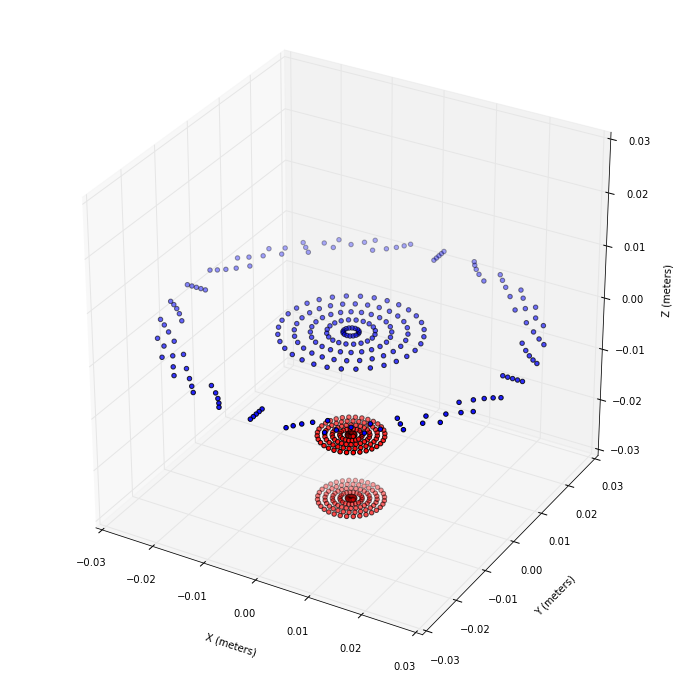

In [5]:
em_outside = disk_magnet(np.array([0, 0, 0]), .028, .0325, SLICES, .7)
em_inside = disk_magnet(np.array([0, 0, 0]), 0, .0135, SLICES, -.7)
# em = em_inside
em = em_outside + em_inside
# print(em)

gap = 0.020
radius = 0.00635
thickness = 0.0127

perm = cylinder_magnet(np.array([0, 0, -gap]), radius, thickness, .6619, color='r')
print(em.force_on(perm))
plot_magnet([perm, em])

In [11]:
def zforce(gap):
    em_outside = disk_magnet(np.array([0, 0, 0]), .028, .0325, SLICES, .7)
    em_inside = disk_magnet(np.array([0, 0, 0]), 0, .0135, SLICES, -.7)
    em = em_outside + em_inside

    radius = 0.00635
    thickness = 0.0127

    perm = cylinder_magnet(np.array([0, 0, -gap]), radius, thickness, .6619, color='r')

    return em.force_on(perm)[2]

gaps = np.linspace(.1e-2, 3e-2, num=20)
zforces = [zforce(gap) for gap in gaps]

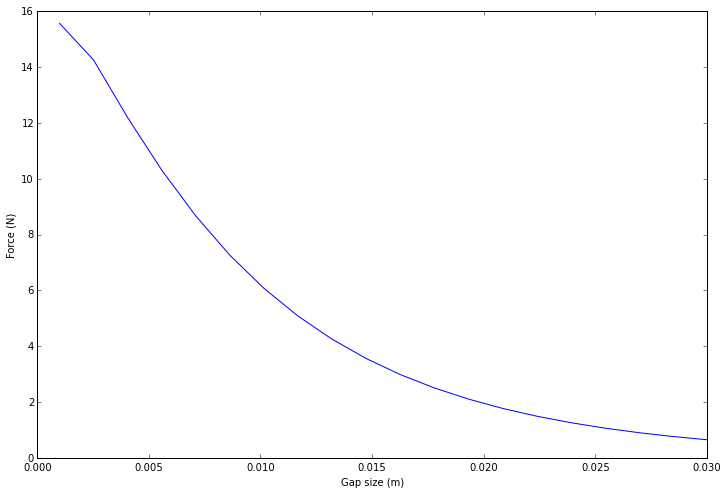

In [12]:
fig = plt.figure(figsize=(12, 8))
p = fig.add_subplot(111)

p.plot(gaps, zforces)
p.set_xlabel('Gap size (m)')
p.set_ylabel('Force (N)')


<b>Proposed magnet geometry</b><br>
This is the proposed magnet geometry as specified in Draft EM Anchor Design, 2015-11-01. The dimensional surface geometry of the internal magnet is incorrect, as I'm simulating it using a bar shape instead of a cylinder shape. Until I learn how to distribute charges along the curved surface of a cylinder magnet though, this is a decent approximation.

Also, the computations for flux are a complete estimate as well. Until I better understand magnetic circuits, such as somebody answering the questions I sent out in email, I'm not 100% how to compute that correctly.

[ -8.11850587e-16  -8.02201187e-16   1.24105636e+01]


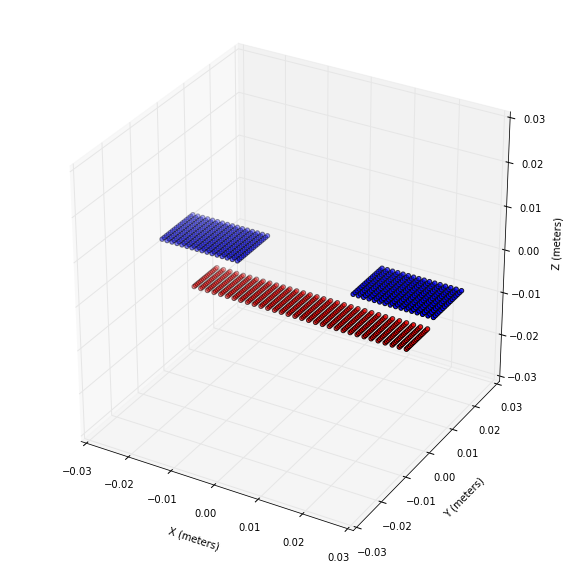

In [14]:
b_em = .7
rect1 = rectangle_magnet(b_em, np.array([(1.27e-2), 0, 0]), 1.905e-2, 1.27e-2)
rect2 = rectangle_magnet(-b_em, np.array([(-1.905e-2)-(1.27e-2), 0, 0]), 1.905e-2, 1.27e-2)
em = rect1+rect2

gap = 1e-2

b_perm = .6619
rect1 = rectangle_magnet(-b_em, np.array([0, .15875e-2, -gap]), 2.54e-2, .9525e-2)
rect2 = rectangle_magnet(b_em, np.array([(-1.905e-2)-(1.27e-2)+(.635e-2), .15875e-2, -gap]), 2.54e-2, .9525e-2)
perm = rect1+rect2
perm.color='r'

print(em.force_on(perm))
plot_magnet([em, perm])

In [17]:
def zforce(gap):
    b_em = 1
    rect1 = rectangle_magnet(b_em, np.array([(1.27e-2), 0, 0]), 1.905e-2, 1.27e-2)
    rect2 = rectangle_magnet(-b_em, np.array([(-1.905e-2)-(1.27e-2), 0, 0]), 1.905e-2, 1.27e-2)
    em = rect1+rect2

    b_perm = .6619
    rect1 = rectangle_magnet(-b_em, np.array([0, .15875e-2, -gap]), 2.54e-2, .9525e-2)
    rect2 = rectangle_magnet(b_em, np.array([(-1.905e-2)-(1.27e-2)+(.635e-2), .15875e-2, -gap]), 2.54e-2, .9525e-2)
    perm = rect1+rect2

    return em.force_on(perm)[2]

gaps = np.linspace(.1e-2, 3e-2, num=20)
zforces = [zforce(gap) for gap in gaps]



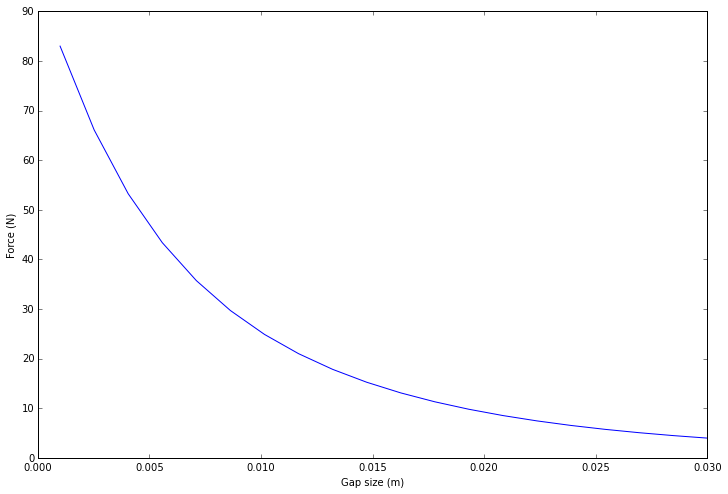

In [16]:
fig = plt.figure(figsize=(12, 8))
p = fig.add_subplot(111)

p.plot(gaps, zforces)

p.set_xlabel('Gap size (m)')
p.set_ylabel('Force (N)')
